In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import re
from pathlib import Path

In [ ]:
from get_to_know_data import load_data, summarize_data

In [19]:
# get a list of all files in directory
output_dir = Path("../data_sync/outputs/")
data_files = list(output_dir.glob("*.csv"))
print(len(data_files))

27


In [23]:
file = data_files[0]
print(f"Processing file: {file}")
data = load_data(file)
print(data.head())

Processing file: ../data_sync/outputs/BIA24-17_WR_merged_with_gear.csv
   sessionid                 tt_s  distance_m  slope_pct  speed_kmph  power_w  \
0       2426  2024-09-11 07:26:19       80.34        0.0        24.2    404.0   
1       2426  2024-09-11 07:26:20       87.66        0.0        24.0    404.0   
2       2426  2024-09-11 07:26:21       94.96        0.0        24.0    376.0   
3       2426  2024-09-11 07:26:22      101.85        0.0        24.0    340.0   
4       2426  2024-09-11 07:26:23      108.19        0.0        24.4    317.0   

   heartrate_bpm  frequency_ppm  cycle  thrust_left_ms  ...  ns1:BuildMajor8  \
0            0.0           72.0    7.0           230.0  ...              0.0   
1            0.0           70.0    8.0           200.0  ...              0.0   
2            0.0           70.0    9.0           180.0  ...              0.0   
3            0.0           70.0   10.0           170.0  ...              0.0   
4            0.0           68.0   12.0    

In [24]:
# Print all column names
print("Column names:")
print(data.columns.tolist())
print(f"\nTotal number of columns: {len(data.columns)}")

Column names:
['sessionid', 'tt_s', 'distance_m', 'slope_pct', 'speed_kmph', 'power_w', 'heartrate_bpm', 'frequency_ppm', 'cycle', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'treadmill_force_n', 'altitude_m', 'latitude_deg', 'longitude_deg', 'usernote = BIA24-17WR', 'Sport', 'ns1:Id', 'StartTime', 'ns1:TotalTimeSeconds', 'ns1:DistanceMeters', 'ns1:MaximumSpeed', 'ns1:Calories', 'ns1:Value', 'ns1:Value2', 'ns1:Intensity', 'ns1:TriggerMethod', 'ns1:Time', 'ns1:AltitudeMeters', 'ns1:DistanceMeters3', 'ns1:Value4', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'ns2:AvgSpeed', 'ns2:AvgRunCadence', 'ns2:MaxRunCadence', 'ns2:AvgWatts', 'ns2:MaxWatts', 'ns1:Name', 'ns1:UnitId', 'ns1:ProductID', 'ns1:VersionMajor', 'ns1:VersionMinor', 'ns1:BuildMajor', 'ns1:BuildMinor', 'ns1:Name5', 'ns1:VersionMajor6', 'ns1:VersionMinor7', 'ns1:BuildMajor8', 'ns1:BuildMinor9', 'ns1:La

In [26]:
info_columns = ['tt_s', 'Lap', 'Gear', 'ns1:LatitudeDegrees', 'ns1:LongitudeDegrees', 'Sport'] 
feature_columns_pole_data = ['speed_kmph', 'power_w', 'frequency_ppm', 'thrust_left_ms', 'thrust_right_ms', 'impulse_left_ns', 'impulse_right_ns', 'force_meanl_n', 'force_meanr_n', 'f_tot_mean_n', 'altitude_m']
feature_columns_gnss = ['ns1:AltitudeMeters', 'ns2:Speed', 'ns2:RunCadence', 'ns2:Watts']

In [36]:
def plot_histogram_with_gear_label(df, column):
    """Plot a histogram of a specified column in the DataFrame, separated by gear."""
    plt.figure(figsize=(10, 6))
    
    # Get unique gear values
    gears = df['Gear'].dropna().unique()
    
    # Plot histogram for each gear
    for gear in gears:
        gear_data = df[df['Gear'] == gear][column].dropna()
        plt.hist(gear_data, bins=30, alpha=0.5, label=f'Gear {gear}')
    
    plt.title(f'Histogram of {column} by Gear')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()    
    plt.show()

In [ ]:
def preprocess_data(df):
    # Select only relevant columns
    selected_columns = info_columns + feature_columns_pole_data + feature_columns_gnss
    df = df[selected_columns]
    summarize_data(df)
    # print unique gear values
    print("Unique gear values:", df['Gear'].unique())
    print("Gear value counts:")
    print(df['Gear'].value_counts())
    for col in feature_columns_pole_data + feature_columns_gnss:
        plot_histogram_with_gear_label(df, col)

Data Summary:
               Lap  ns1:LatitudeDegrees  ns1:LongitudeDegrees   speed_kmph  \
count  1290.000000          1290.000000           1290.000000  1290.000000   
mean      2.014729            63.191128             14.664368    18.046977   
std       0.812394             0.001106              0.003328     9.618106   
min       1.000000            63.188661             14.657264     0.700000   
25%       1.000000            63.190304             14.661547     9.500000   
50%       2.000000            63.191278             14.664980    17.200000   
75%       3.000000            63.192215             14.667484    25.100000   
max       3.000000            63.192668             14.668209    43.300000   

           power_w  frequency_ppm  thrust_left_ms  thrust_right_ms  \
count  1290.000000    1290.000000     1290.000000      1290.000000   
mean    113.286047      41.731008      127.620155       200.147287   
std      75.728085      25.745241       84.130168       119.178309   
min

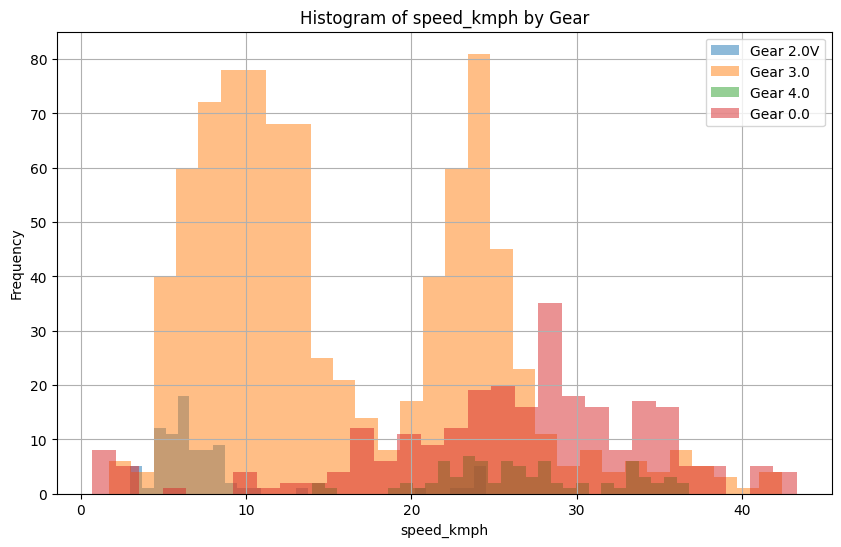

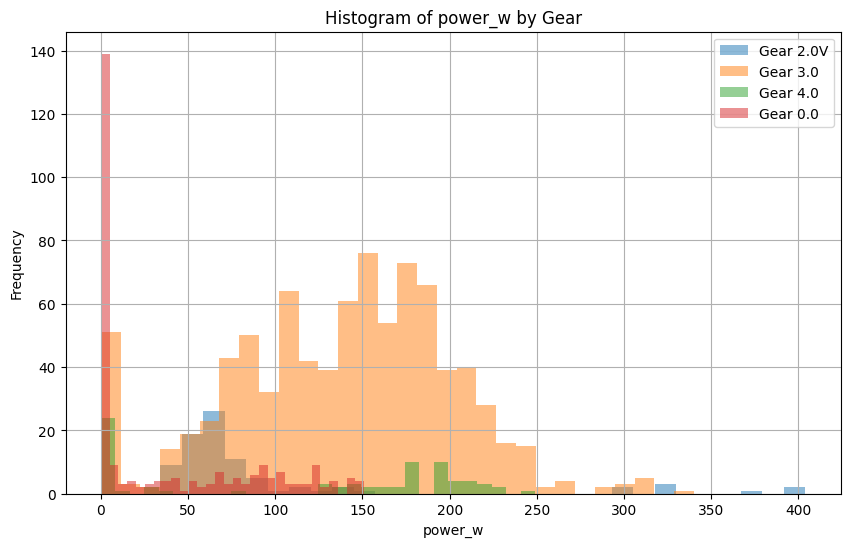

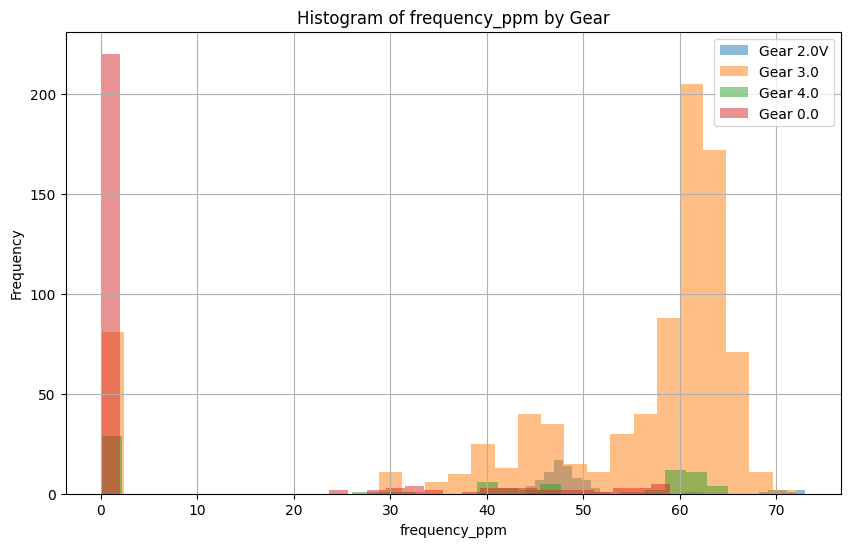

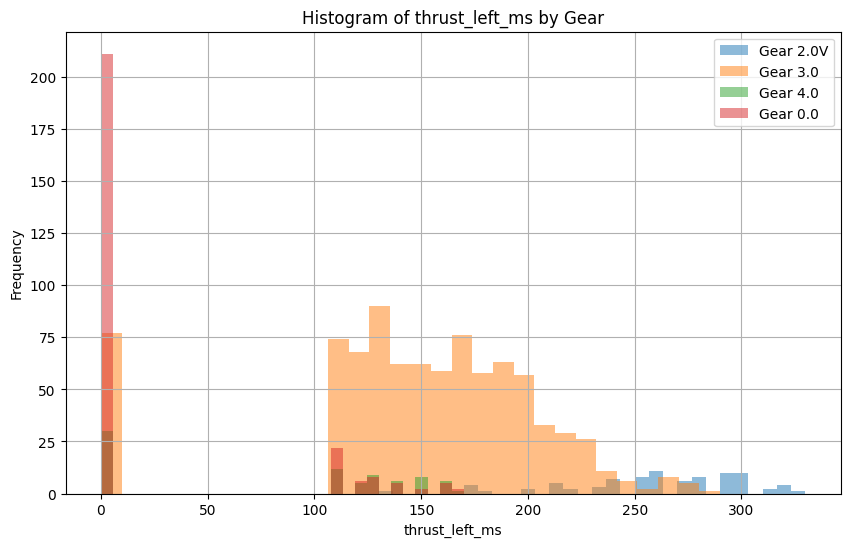

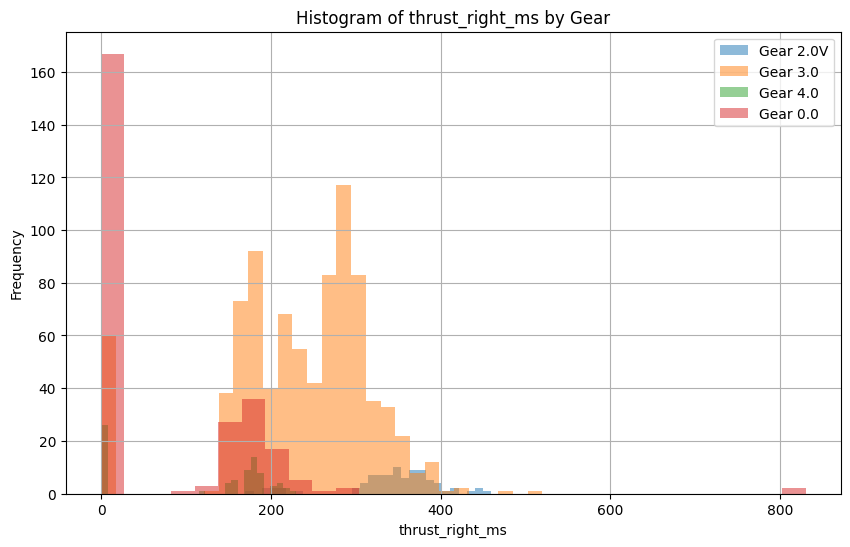

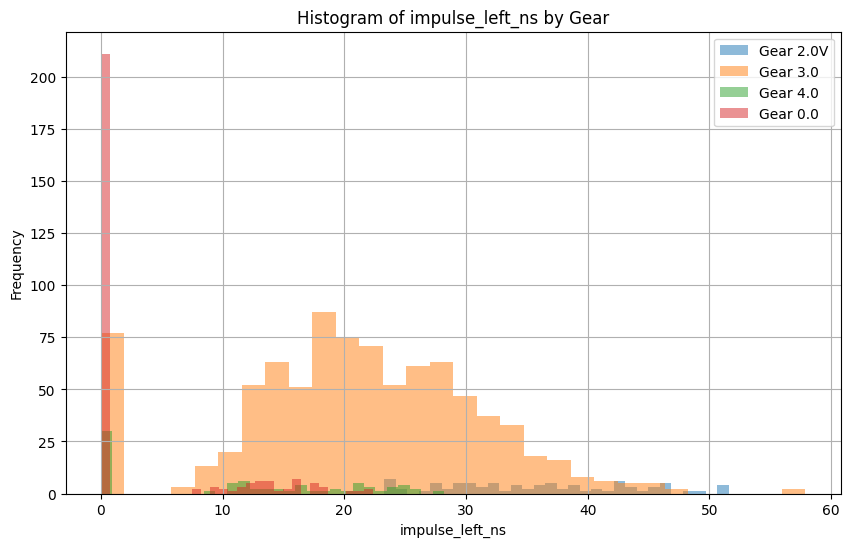

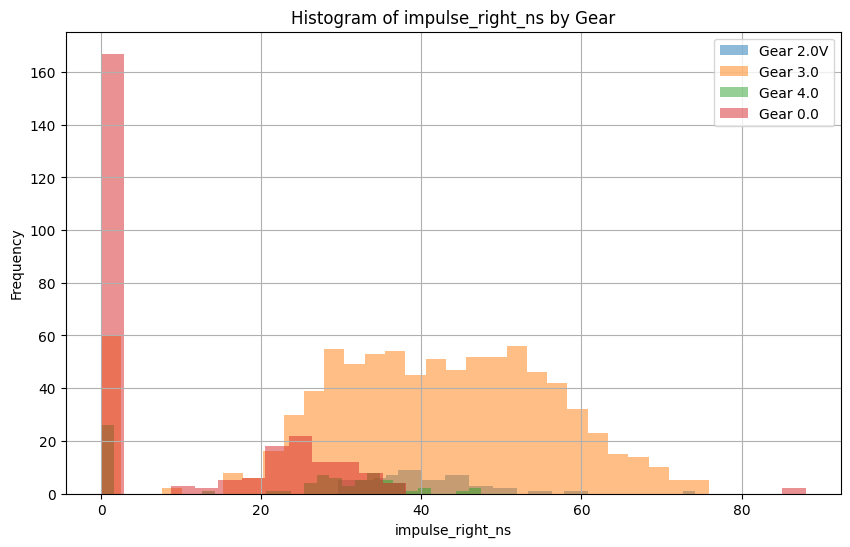

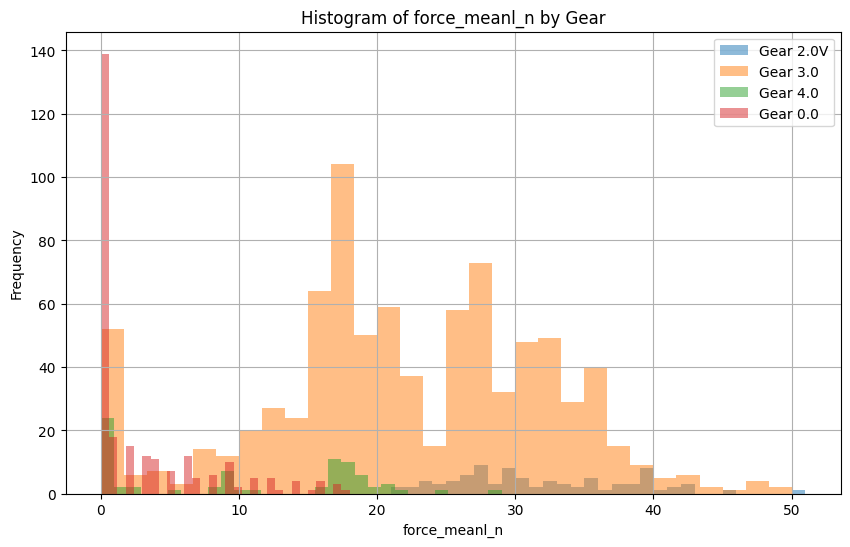

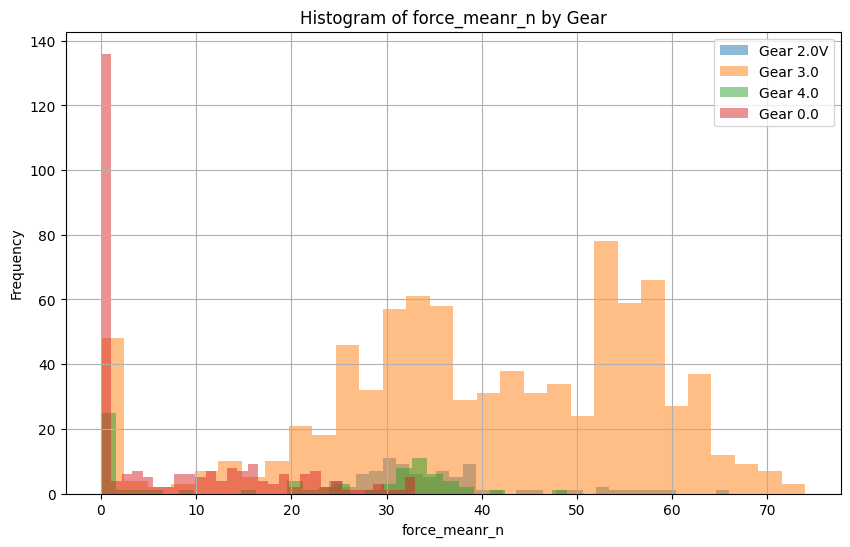

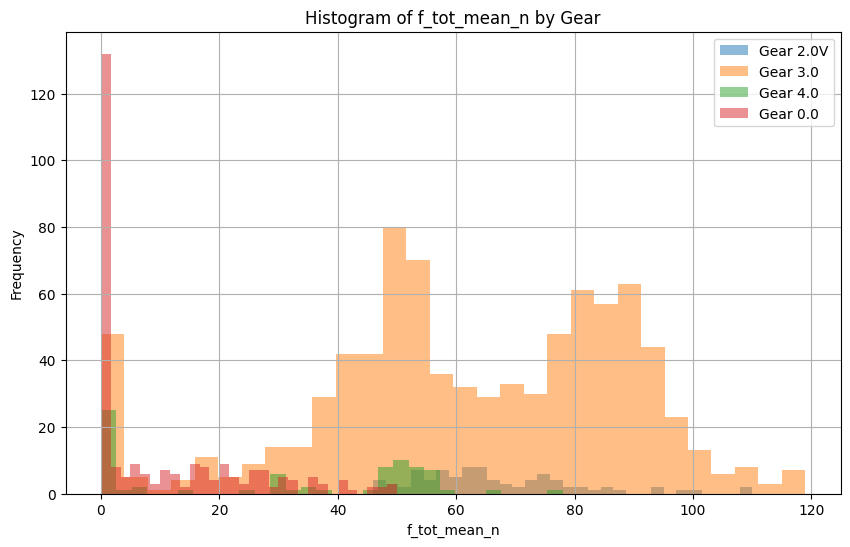

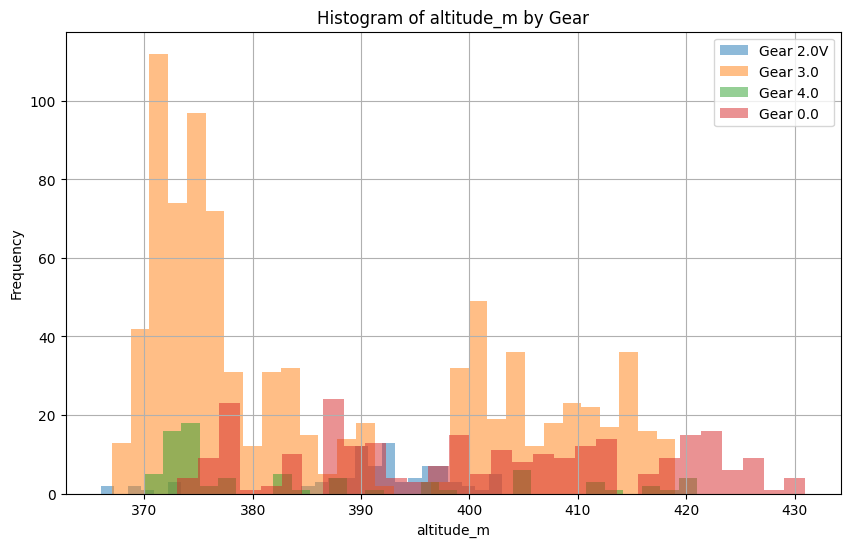

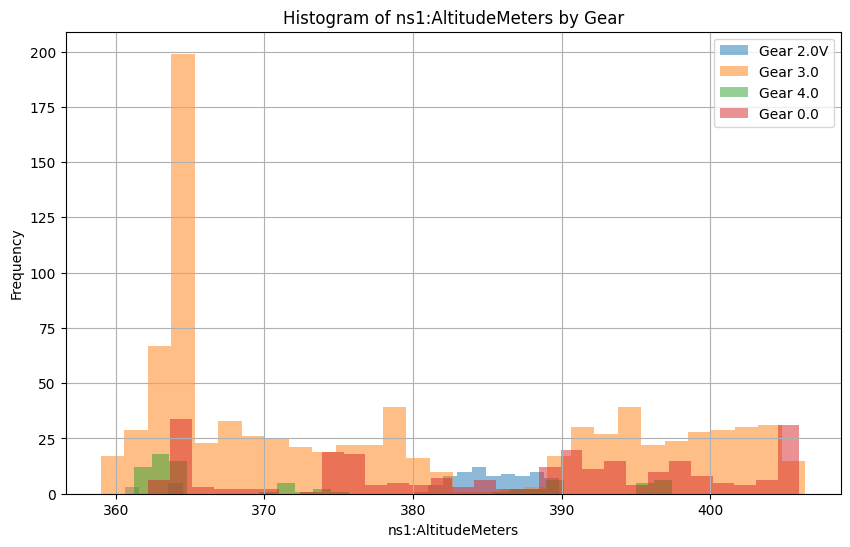

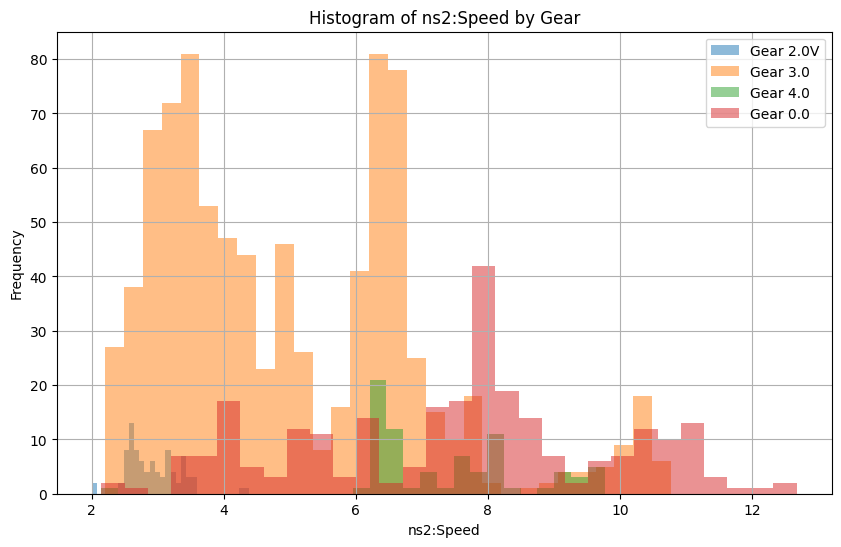

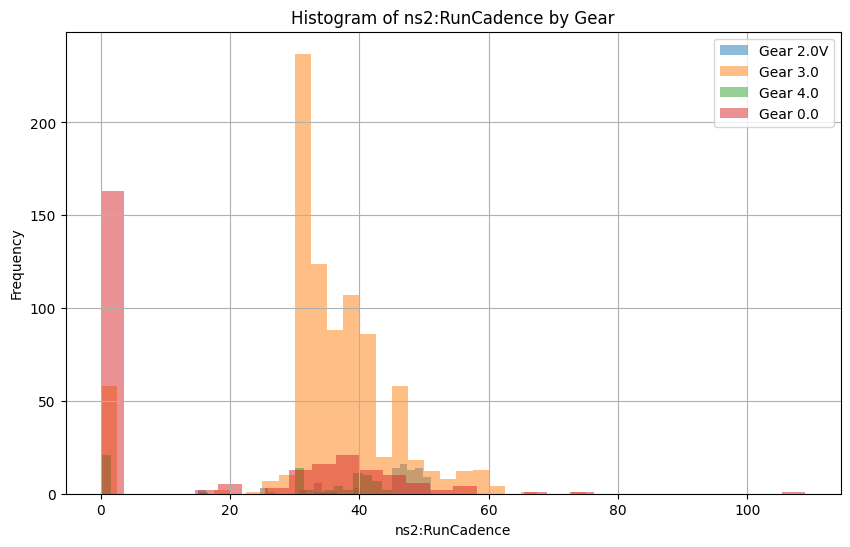

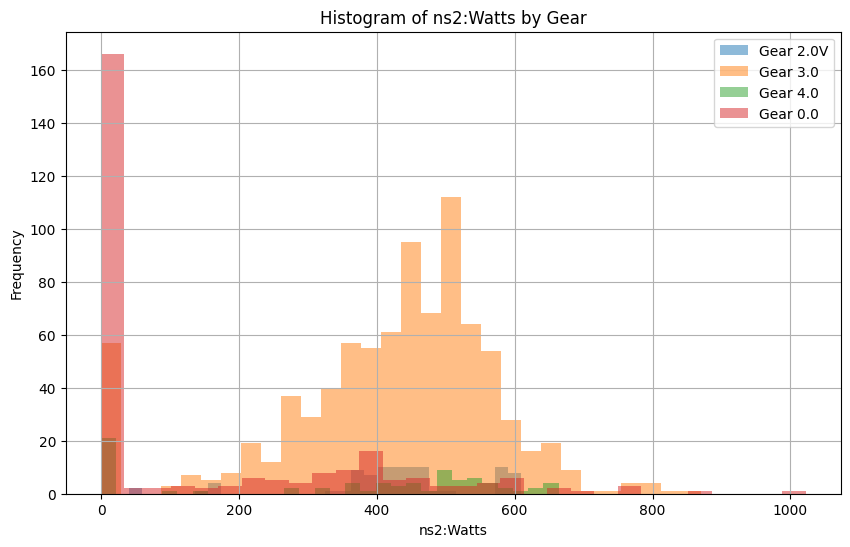

In [39]:
preprocess_data(data)